In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import pickle
from typing import List, Tuple, Dict, Any
import eval_repeatability as er
import config_repeatability as cfg_rep
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [3]:
detector_name='sift'

In [4]:
dir_output = '../../output_evaluation/detectors'
fp_output = os.path.join(dir_output, '{}.pkl'.format(detector_name))

### Lade Daten

In [80]:
with open(fp_output, 'rb') as src:
    data = pickle.load(src, encoding='utf-8')

### Hilfsfunktionen

In [33]:
def stats__num_kpts(
    collection_name:str, 
    set_name:str, 
    data:Dict, 
    config:Dict, 
    fs:Dict) -> None:
    """Erstelle Meta-Metriken zur Anzahl gefundener Kepunkte 
    innerhalb eines Sets."""
    stats = data[collection_name][set_name]['stats_num_kpts']
    print('{}:'.format(config['detector_name']))
    print('durchschnittliche Anzahl Keypunkte:\t\t{0:.2f}+/-{1:.2f}'.format(stats['avg'], stats['std']))
    print('max. Anzahl gefundener Keypunkte:\t\t', stats['val_max'])
    print('min. Anzahl gefundener Keypunkte:\t\t', stats['val_min'])
    print('Anzahl an Extrema:\t\t\t\t', stats['num_extrema'])
    print('\tdavon oberhalb Standardabweichung:\t', stats['num_extrema_gt_std'])
    print('\tdavon unterhalb Standardabweichung:\t', stats['num_extrema_lt_std'])
    

In [86]:
def stats__perc_matching_kpts_for_e(
    collection_name:str,
    set_name:str,
    data:Dict,
    config:Dict,
    fs:Dict,
    epsilon:int=1) -> None:
    stats = data[collection_name][set_name]['stats_perc_matching_kpts_for_e_{}'.format(epsilon)]
    
    print('{}:'.format(config['detector_name']))
    print('durchschnittliche Prozent an gematchen Keypunkten:\t\t{0:.2f}+/-{1:.2f}'.format(stats['avg'], stats['std']))
    print('max. Anzahl gematchter Keypunkte:\t\t', stats['val_max'])
    print('min. Anzahl gematchter Keypunkte:\t\t', stats['val_min'])
    print('Anzahl an Extrema:\t\t\t\t', stats['num_extrema'])
    print('\tdavon oberhalb Standardabweichung:\t', stats['num_extrema_gt_std'])
    print('\tdavon unterhalb Standardabweichung:\t', stats['num_extrema_lt_std'])


In [6]:
def eval_repeatability_for_set(
    collection_name:str,
    set_name:str,
    data:Dict,
    config:Dict,
    fs:Dict) -> None:
    # Finde für jedes Bild i die durchschnittliche Prozenteanzahl
    # an gematchten Keypunkten mit jedem anderen Bild j, (i != j).
    
    heatmap = data[collection_name][set_name]['perc_matching_kpts_for_e_1'].values
    
    # create a mask, that hides diagonal elements
    mask = np.ones(heatmap.shape).astype('int')
    np.fill_diagonal(mask, 0)

    # Remove the diagonal elements within the square array to create
    # an new matrix from NxN to Nx(N-1)
    rows = heatmap[np.where(mask)].reshape(heatmap.shape[0], heatmap.shape[1]-1)
    
    # Create a new array containing the mean value of each row. (1, N-1).
    # And compute the mean value of that too.
    y = rows.mean(axis=1)
    avg = y.mean()
    std = y.std()
    
    val_min = np.min(y)
    val_max = np.max(y)
    idx_min = np.argmin(y)
    idx_max = np.argmax(y)
    
    extrema = y[(y < avg-std) | (y > avg+std)].flatten()
    num_extrema = len(extrema)
    num_extrema_lt_std = len(y[y < avg-std].flatten())
    num_extrema_gt_std = len(y[y > avg+std].flatten())
    
    print('{}:'.format(config['detector_name']))
    print('durchschnittliche Prozent an gematchen Keypunkten:\t\t{0:.2f}+/-{1:.2f}'.format(avg, std))
    print('max. Anzahl gematchter Keypunkte:\t\t', val_max)
    print('min. Anzahl gematchter Keypunkte:\t\t', val_min)
    print('Anzahl an Extrema:\t\t\t\t', num_extrema)
    print('\tdavon oberhalb Standardabweichung:\t', num_extrema_gt_std)
    print('\tdavon unterhalb Standardabweichung:\t', num_extrema_lt_std)

### Plot Funktionen

In [7]:
def plot_example_images(
    collection_name:str, 
    set_name:str, 
    config:Dict, 
    fs:Dict,
    direction:str='horizontal'): # alternative: 'vertical'
    image_dir = os.path.join(config['image_dir'], collection_name, set_name)
    image_names = os.listdir(image_dir)
    
    _image_names = [image_names[0], 
                 image_names[int(0.5 * len(image_names))], 
                 image_names[-1]]

    _imgs = []
    for _image_name in _image_names:
        img = cv2.imread(os.path.join(image_dir, _image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        _imgs.append(img)
    
    if direction == 'horizontal':
        fig, axes = plt.subplots(nrows=1, ncols=3)
        plt.rcParams['figure.figsize'] = [16, 4]
    else:
        fig, axes = plt.subplots(nrows=3, ncols=1)
        plt.rcParams['figure.figsize'] = [16, 6]
    
    
    fig.suptitle('Beispielbilder aus dem Set {}'.format(set_name), fontsize=16)
    for idx, ax in enumerate(axes):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(_imgs[idx])

In [8]:
def plot_num_kpts(
    collection_name:str,
    set_name:str,
    data:Dict,
    config:Dict,
    fs:Dict
    ) -> None:
    plt.rcParams['figure.figsize'] = [16, 9]
    y = data[collection_name]['num_kpts'].loc[fs[collection_name][set_name]].values.flatten()
    x = list(range(len(y)))

    # Find min/max values and their indices in y.
    idx_min = np.argmin(y)
    idx_max = np.argmax(y)
    val_min = np.min(y)
    val_max = np.max(y)

    # Get average and standard deviation.
    avg = data[collection_name][set_name]['avg_num_kpts']
    std = data[collection_name][set_name]['std_num_kpts']

    x_lt_std = np.argwhere(y < avg-std).flatten()
    y_lt_std = y[y < avg-std].flatten()

    x_gt_std = np.argwhere(y > avg+std).flatten()
    y_gt_std = y[y > avg+std].flatten()

    fig, ax = plt.subplots(nrows=1, ncols=1)
    # ax.add_patch(mpl.patches.Polygon(
    #     [[-3, avg-std],[-3, avg+std],[x[-1], avg+std],[x[-1], avg-std]], 
    #     hatch='///', 
    #     color='blue', 
    #     lw=0,
    #     alpha=0.2,
    #     fill=False))


    # Plot number of keypoints.
    ax.bar(x, y, color='C0')
    ax.bar(x_lt_std, y_lt_std, color='navy')
    ax.bar(x_gt_std, y_gt_std, color='navy')

    # Draw average and standard devation.
    ax.axhline(y=avg, color='orange', label='mean')
    ax.axhline(y=avg+std, color='orange', linestyle=':', alpha=1)
    ax.axhline(y=avg-std, color='orange', linestyle=':', alpha=1)

    if val_min == val_max:
        ax.text(
        idx_max - 0.125, 
        val_max - int(val_max / 20),
        'max/max: {}'.format(val_max),
        color='white',
        rotation=90);

    else:
        # insert max value text
        ax.text(
            idx_max - 0.125, 
            val_max - int(val_max / 20),
            'max: {}'.format(val_max),
            color='white',
            rotation=90);

        # insert min value text
        ax.text(
            idx_min - 0.125, 
            val_min - int(val_min / 10), 
            'min: {}'.format(val_min),
            color='white',
            rotation=90);

    ax.set_title('{} - Anzahl gefundener Keypunkte für das Set {}.'.format(config['detector_name'], set_name))
    ax.set_ylabel('Anzahl gefundener Keypunkte in Bild i');
    ax.set_xlabel('Das i-te Bild');

In [9]:
def plot_num_kpts_extrema(
    collection_name:str, 
    set_name:str, 
    data:Dict, 
    config:Dict, 
    fs:Dict,
    direction:str='horizontal') -> None:
    
    y = data[collection_name]['num_kpts'].loc[fs[collection_name][set_name]].values.flatten()
    image_dir = os.path.join(config['image_dir'], collection_name, set_name)
    kpts_image_names = sorted([config['kpts_image_format'].format(x[:-4], config['max_size']) for x in os.listdir(image_dir)])

    data_dir = os.path.join(config['data_dir'], collection_name, set_name, 'keypoint_images', detector_name)
    idx_min = np.argmin(y)
    idx_max = np.argmax(y)
    
    # If min and max are the same, but there are also other entries
    # with the same max value, take the next one.
    if idx_min == idx_max:
        _maxes = np.where(y == np.max(y))[0].flatten()
        if len(_maxes) > 1:
            idx_max = _maxes[1]

    titles = ['{} - Bild mit wenigsten Keypunkten ({})', '{} -Bild mit meisten Keypunkten ({})']
    num_kpts = [y[idx_min], y[idx_max]]
    image_names = [kpts_image_names[idx_min], kpts_image_names[idx_max]]

    images = []
    for image_name in image_names:
        img = cv2.imread(os.path.join(data_dir, image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

    if direction == 'horizontal':
        plt.rcParams['figure.figsize'] = [16, 16]
        fig, axes = plt.subplots(nrows=1, ncols=2)
    else:
        plt.rcParams['figure.figsize'] = [16, 6]
        fig, axes = plt.subplots(nrows=2, ncols=1)
    
    for i in range(len(images)):
        ax = axes[i]
        ax.imshow(images[i])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[i].format(config['detector_name'], num_kpts[i]))

In [10]:
def plot_repeatability_heatmap(
    collection_name:str,
    set_name:str,
    data:Dict,
    config:Dict,
    fs:Dict) -> None:
    heatmap = data[collection_name][set_name]['perc_matching_kpts_for_e_1'].values
    
    plt.rcParams['figure.figsize'] = [10, 10]    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    im = ax.imshow(heatmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=cax);
    
    ax.set_title('{} - Prozentuale Wiederholbarkeit für alle Bildpaare.'.format(config['detector_name']))

In [45]:
def plot_repeatability(
    collection_name:str,
    set_name:str,
    data:Dict,
    config:Dict,
    fs:Dict) -> None:
    # Finde für jedes Bild i die durchschnittliche Prozenteanzahl
    # an gematchten Keypunkten mit jedem anderen Bild j, (i != j).
    plt.rcParams['figure.figsize'] = [16, 9]
    
    heatmap = data[collection_name][set_name]['perc_matching_kpts_for_e_1'].values
    
    # create a mask, that hides diagonal elements
    mask = np.ones(heatmap.shape).astype('int')
    np.fill_diagonal(mask, 0)

    # Remove the diagonal elements within the square array to create
    # an new matrix from NxN to Nx(N-1)
    rows = heatmap[np.where(mask)].reshape(heatmap.shape[0], heatmap.shape[1]-1)
    
    # Create a new array containing the mean value of each row. (1, N-1).
    # And compute the mean value of that too.
    y = rows.mean(axis=1)
    avg = y.mean()
    std = y.std()

    fig, ax = plt.subplots(nrows=1, ncols=1)
    for r in rows:
        ax.plot(r, alpha=0.1)
    ax.plot(y)
    
    ax.axhline(avg, label='{0:.2f}'.format(avg), color='orange')
    ax.axhline(y=avg+std, color='orange', linestyle=':')
    ax.axhline(y=avg-std, color='orange', linestyle=':')
    
    ax.legend();
    
    ax.set_title('{} - Durchschnittliche Wiederholbarkeit der Keypunktsets.'.format(config['detector_name']))

### Konfiguration

In [35]:
config = data['_meta']['config']
fs = data['_meta']['file_system']
detector_name = 'sift'
collection_name = 'webcam'

### Set Chamonix

In [36]:
set_name = 'chamonix'

Zeige drei Bilder aus dem Set. Das erste, letzte und eins in der Mitte.

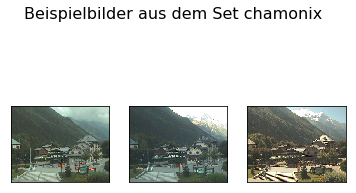

In [14]:
plot_example_images(collection_name, set_name, config, fs)

Zeigt die Anzahl der gefundenen Keypunkte für jedes Bild innerhalb des Sets an. 
Die orange Linie zeigt die durchschnittliche Anzahl gefundener Keypunkte in dem Set an.
Die orange, gepunktete Linie repräsentiert den Durchschnitt plus/minus der Standardabweichung. 
Dunkler markierte Balken liegen außerhalb der doppelten Standardabweichung.

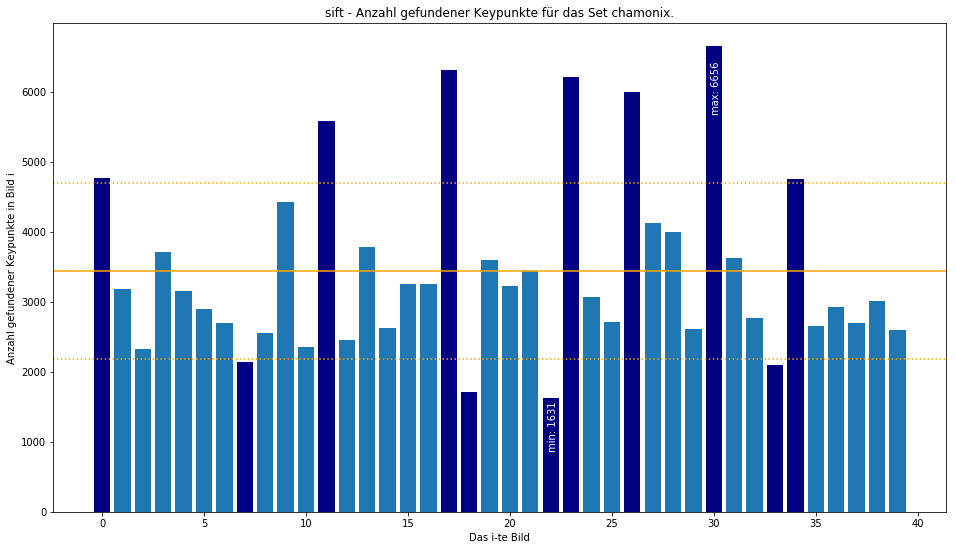

In [15]:
plot_num_kpts(collection_name, set_name, data, config, fs)

Dies sind die Statistiken der oben gezeigten Graphik.

In [37]:
stats__num_kpts(collection_name, set_name, data, config, fs)

sift:
durchschnittliche Anzahl Keypunkte:		3439.57+/-1251.99
max. Anzahl gefundener Keypunkte:		 6656
min. Anzahl gefundener Keypunkte:		 1631
Anzahl an Extrema:				 11
	davon oberhalb Standardabweichung:	 7
	davon unterhalb Standardabweichung:	 4


Ein Beispiel für die unterschiedliche Anzahl gefundener Keypunnkte.

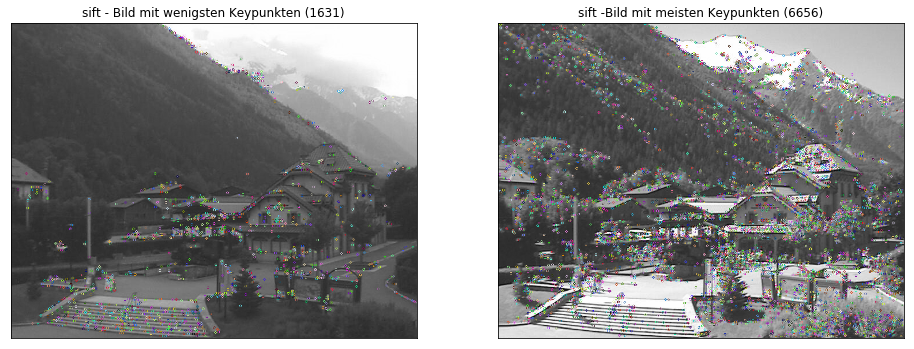

In [17]:
plot_num_kpts_extrema(collection_name, set_name, data, config, fs)

Gibt den Prozentsatz an, mit dem die Keypunkte des Bildes $img_i$ im Partnerbild $img_j$ gefunden wurden.
Die Diagonale stellt dabei das Bildpaar $(img_i, img_j)$ da mit $i = j$, worin natürlich stets alle Keypunkte wiedergefunden werden.

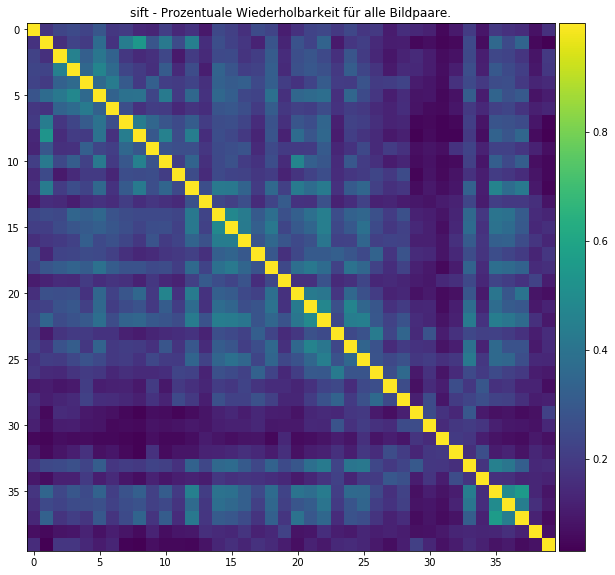

In [18]:
plot_repeatability_heatmap(collection_name, set_name, data, config, fs)

Zeigt die durchschnittliche Wiederholbarkeit, bzw. Wiederfindbarkeit von Keypunkten.
Für jedes Bild $img_i$ existiert ein leicht durchsichtiger Graph, der die prozentuelle Wiederholbarkeit der Keypunkte im Bild $img_i$ in dem Bildpaar $(img_i, img_j)$ angibt.
Der Durchschnitt dieser Werte ist in der dunkelblauen Linie sichtbar und gibt den durchschnittliche Wiederholbarkeit der Keypunkte in Bild $(img_i)$ an.
Die orange Linie stellt die prozentuale Wiederholbarkeit des Detektors auf diesem Set da. Der Wert ist oben rechts in der Legende ersichtlich.

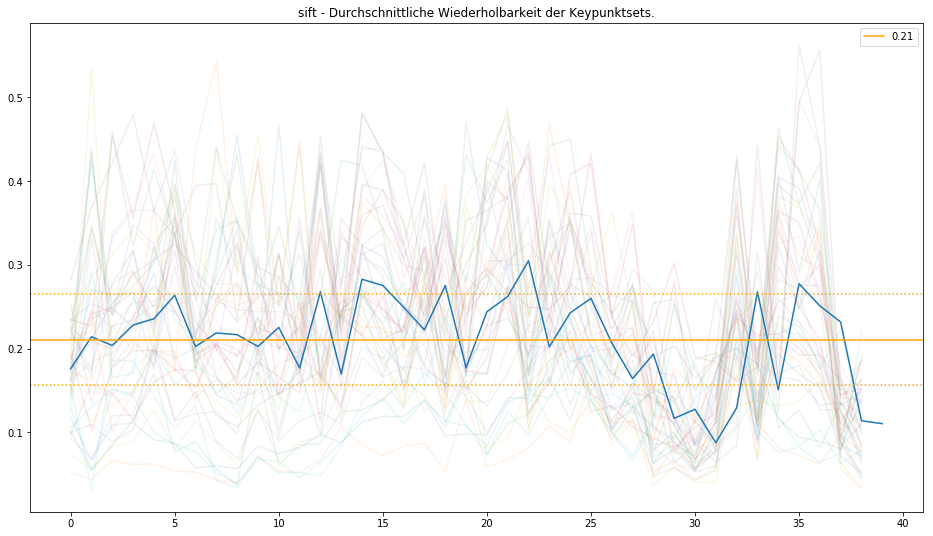

In [46]:
plot_repeatability(collection_name,  set_name, data, config, fs)

In [20]:
stats__perc_matching_kpts_for_e(collection_name, set_name, data, config, fs)

sift:
durchschnittliche Proyzent an gematchen Keypunkten:		0.21+/-0.05
max. Anzahl gematchter Keypunkte:		 0.30481535
min. Anzahl gematchter Keypunkte:		 0.08755213
Anzahl an Extrema:				 14
	davon oberhalb Standardabweichung:	 7
	davon unterhalb Standardabweichung:	 7


### Set Courbevoie

In [21]:
set_name = 'courbevoie'

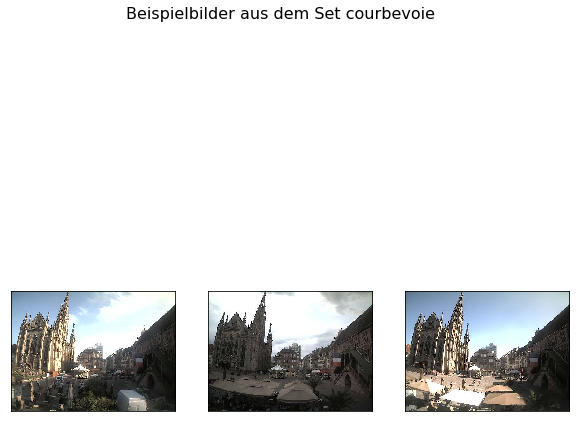

In [22]:
plot_example_images(collection_name, set_name, config, fs)

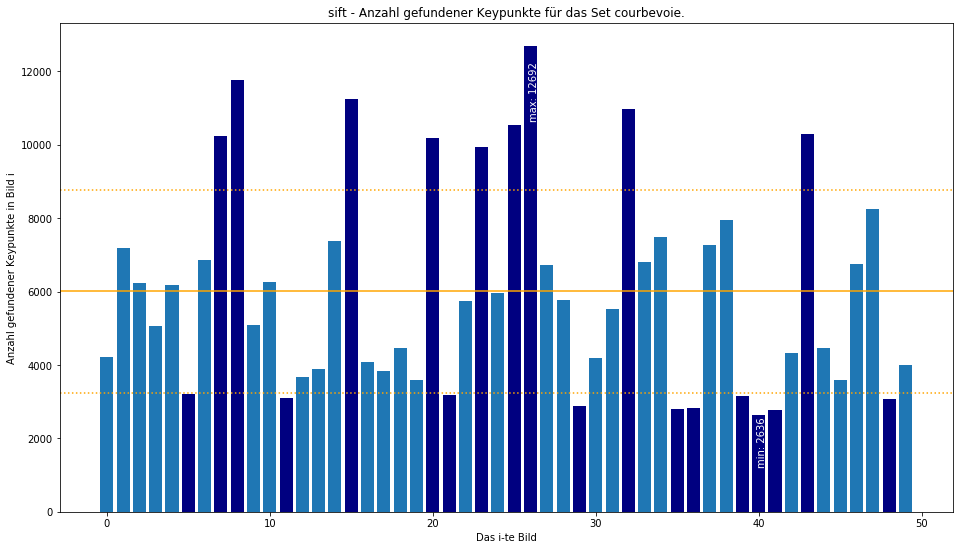

In [23]:
plot_num_kpts(collection_name, set_name, data, config, fs)

In [24]:
stats__num_kpts(collection_name, set_name, data, config, fs)

sift:
durchschnittliche Anzahl Keypunkte:		6004.58+/-2760.36
max. Anzahl gefundener Keypunkte:		 12692
min. Anzahl gefundener Keypunkte:		 2636
Anzahl an Extrema:				 19
	davon oberhalb Standardabweichung:	 9
	davon unterhalb Standardabweichung:	 10


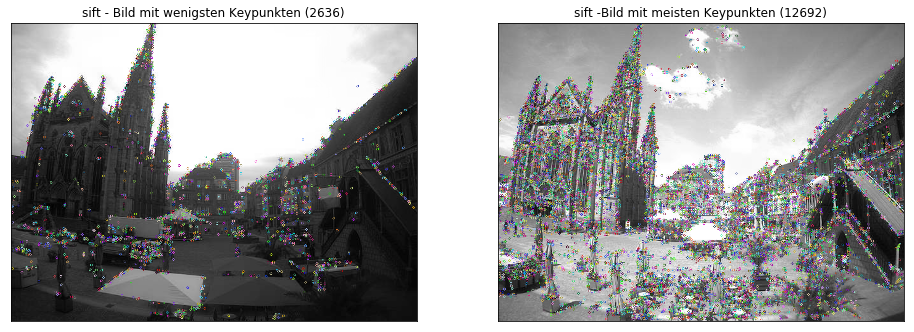

In [25]:
plot_num_kpts_extrema(collection_name, set_name, data, config, fs)

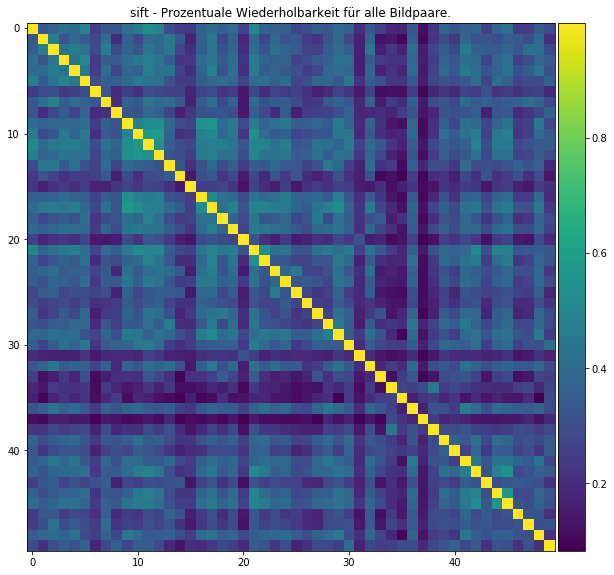

In [26]:
plot_repeatability_heatmap(collection_name, set_name, data, config, fs)

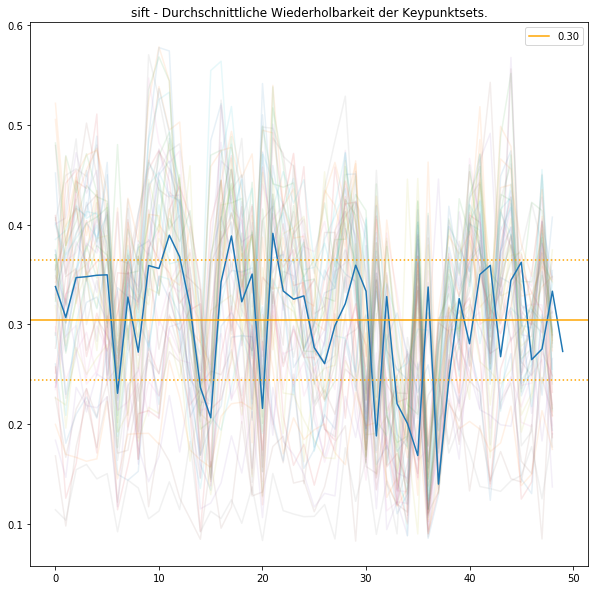

In [27]:
plot_repeatability(collection_name,  set_name, data, config, fs)

In [28]:
stats__perc_matching_kpts_for_e(collection_name, set_name, data, config, fs)

sift:
durchschnittliche Proyzent an gematchen Keypunkten:		0.30+/-0.06
max. Anzahl gematchter Keypunkte:		 0.39123473
min. Anzahl gematchter Keypunkte:		 0.14003709
Anzahl an Extrema:				 13
	davon oberhalb Standardabweichung:	 4
	davon unterhalb Standardabweichung:	 9


### Set Frankurt

In [29]:
set_name = 'frankfurt'

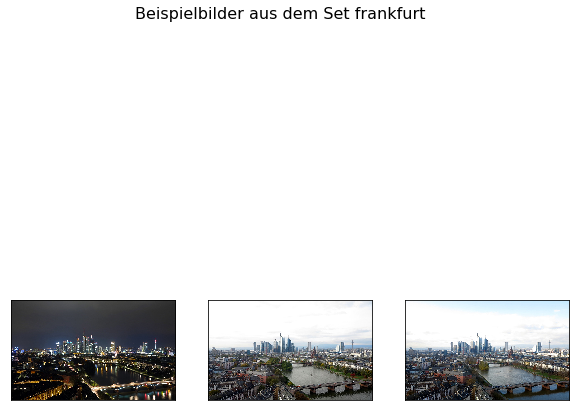

In [30]:
plot_example_images(collection_name, set_name, config, fs)

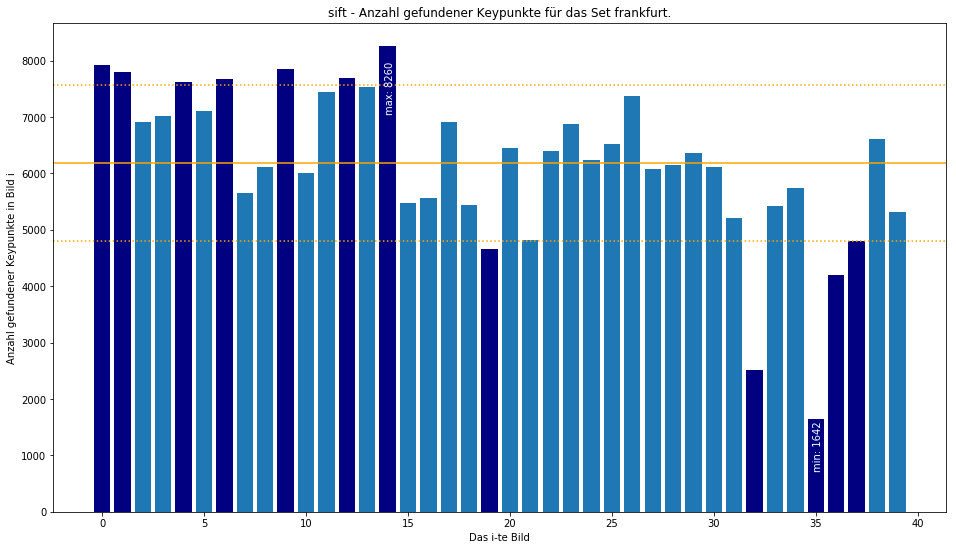

In [31]:
plot_num_kpts(collection_name, set_name, data, config, fs)

In [32]:
stats__num_kpts(collection_name, set_name, data, config, fs)

sift:
durchschnittliche Anzahl Keypunkte:		6186.57+/-1379.24
max. Anzahl gefundener Keypunkte:		 8260
min. Anzahl gefundener Keypunkte:		 1642
Anzahl an Extrema:				 12
	davon oberhalb Standardabweichung:	 7
	davon unterhalb Standardabweichung:	 5


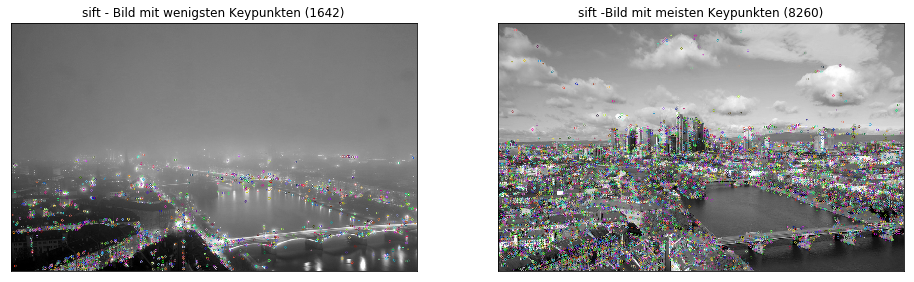

In [33]:
plot_num_kpts_extrema(collection_name, set_name, data, config, fs)

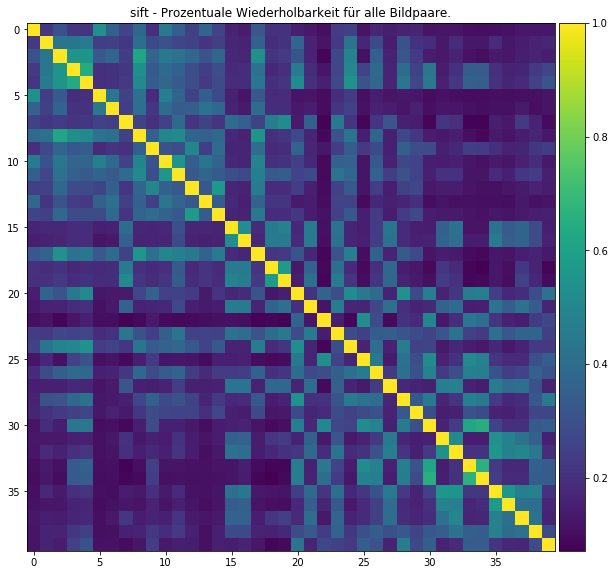

In [34]:
plot_repeatability_heatmap(collection_name, set_name, data, config, fs)

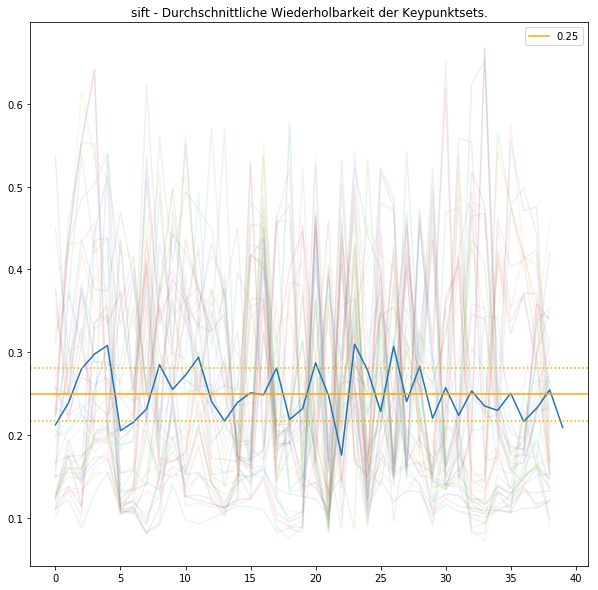

In [35]:
plot_repeatability(collection_name,  set_name, data, config, fs)

In [36]:
stats__perc_matching_kpts_for_e(collection_name, set_name, data, config, fs)

sift:
durchschnittliche Proyzent an gematchen Keypunkten:		0.25+/-0.03
max. Anzahl gematchter Keypunkte:		 0.3096338
min. Anzahl gematchter Keypunkte:		 0.17551489
Anzahl an Extrema:				 16
	davon oberhalb Standardabweichung:	 9
	davon unterhalb Standardabweichung:	 7


### Set Mexico

In [37]:
set_name = 'mexico'

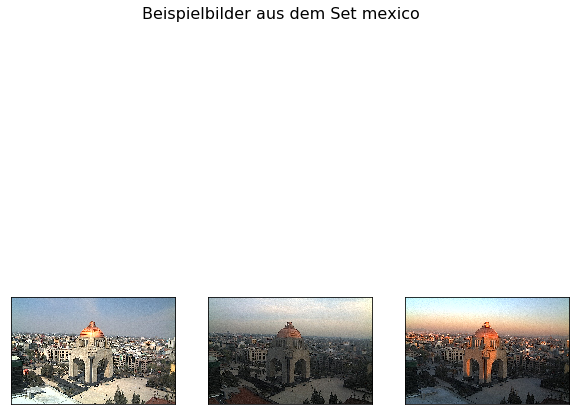

In [38]:
plot_example_images(collection_name, set_name, config, fs)

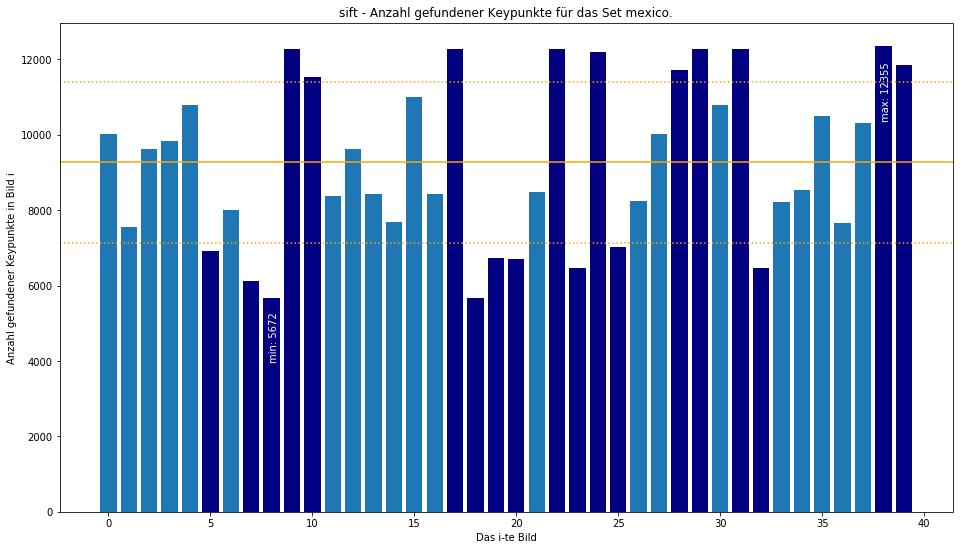

In [39]:
plot_num_kpts(collection_name, set_name, data, config, fs)

In [40]:
stats__num_kpts(collection_name, set_name, data, config, fs)

sift:
durchschnittliche Anzahl Keypunkte:		9268.67+/-2139.95
max. Anzahl gefundener Keypunkte:		 12355
min. Anzahl gefundener Keypunkte:		 5672
Anzahl an Extrema:				 19
	davon oberhalb Standardabweichung:	 10
	davon unterhalb Standardabweichung:	 9


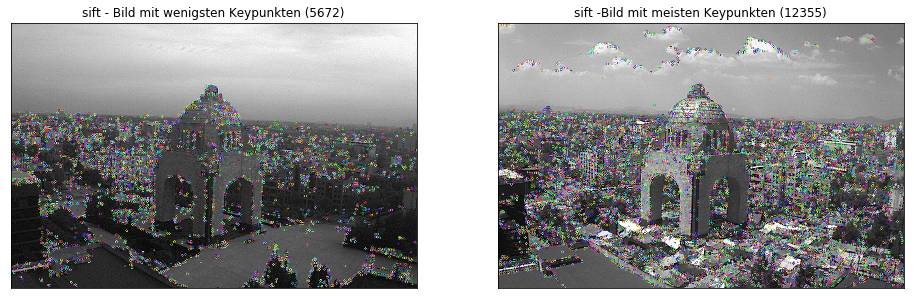

In [41]:
plot_num_kpts_extrema(collection_name, set_name, data, config, fs)

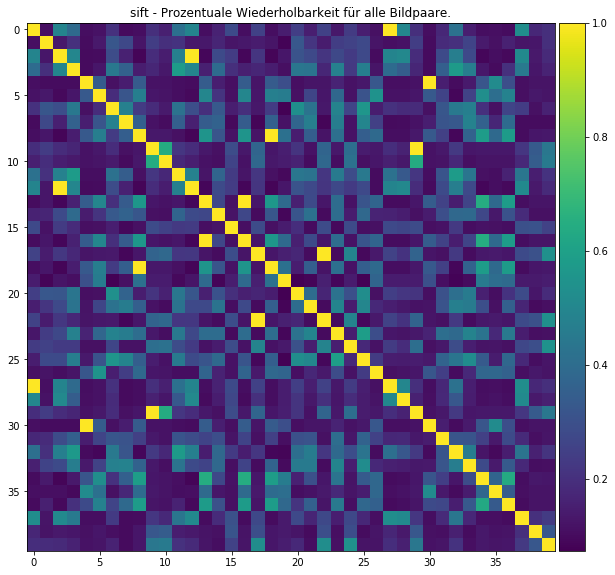

In [42]:
plot_repeatability_heatmap(collection_name, set_name, data, config, fs)

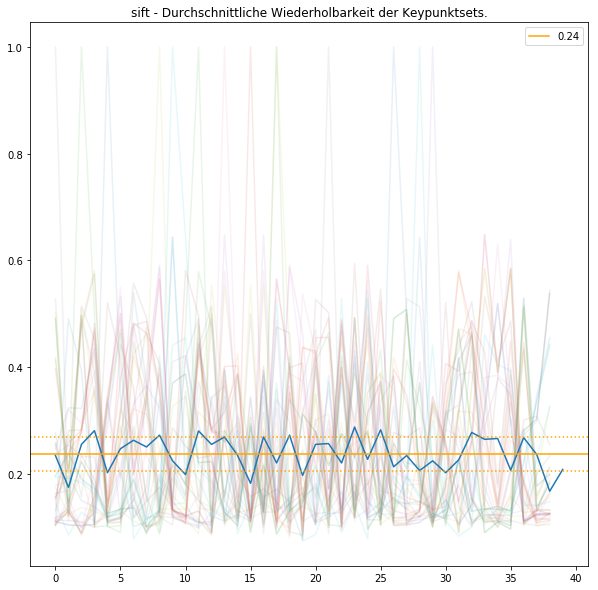

In [43]:
plot_repeatability(collection_name,  set_name, data, config, fs)

In [44]:
stats__perc_matching_kpts_for_e(collection_name, set_name, data, config, fs)

sift:
durchschnittliche Proyzent an gematchen Keypunkten:		0.24+/-0.03
max. Anzahl gematchter Keypunkte:		 0.2875379
min. Anzahl gematchter Keypunkte:		 0.1673371
Anzahl an Extrema:				 14
	davon oberhalb Standardabweichung:	 7
	davon unterhalb Standardabweichung:	 7


### Set Panorama

In [45]:
set_name = 'panorama'

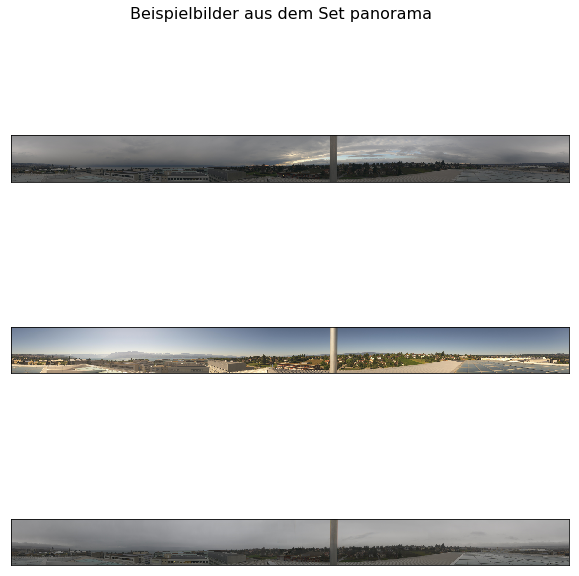

In [46]:
plot_example_images(collection_name, set_name, config, fs, direction='vertical')

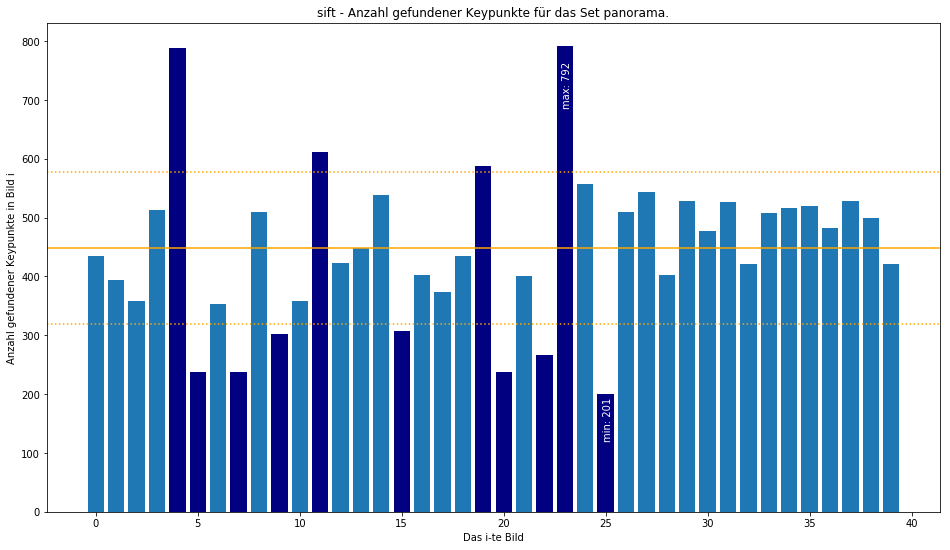

In [47]:
plot_num_kpts(collection_name, set_name, data, config, fs)

In [48]:
stats__num_kpts(collection_name, set_name, data, config, fs)

sift:
durchschnittliche Anzahl Keypunkte:		448.93+/-129.22
max. Anzahl gefundener Keypunkte:		 792
min. Anzahl gefundener Keypunkte:		 201
Anzahl an Extrema:				 11
	davon oberhalb Standardabweichung:	 4
	davon unterhalb Standardabweichung:	 7


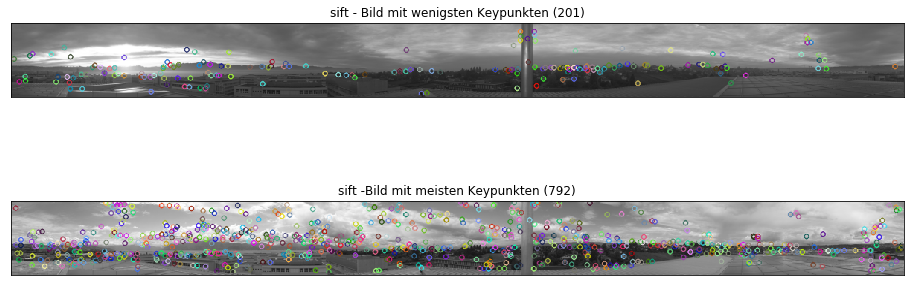

In [49]:
plot_num_kpts_extrema(collection_name, set_name, data, config, fs, direction='vertical')

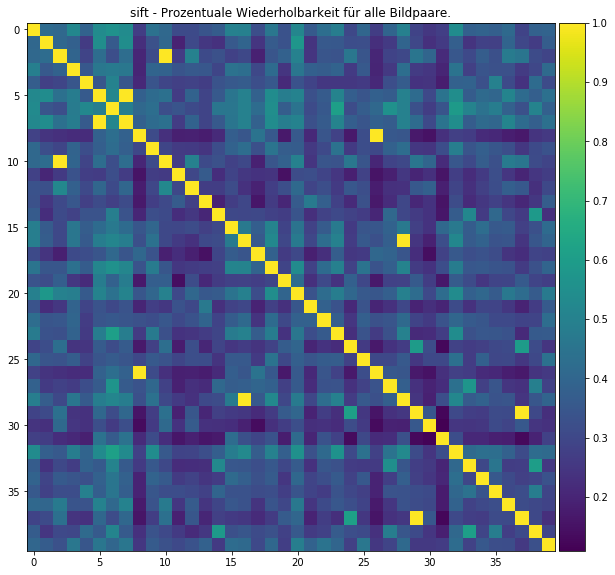

In [50]:
plot_repeatability_heatmap(collection_name, set_name, data, config, fs)

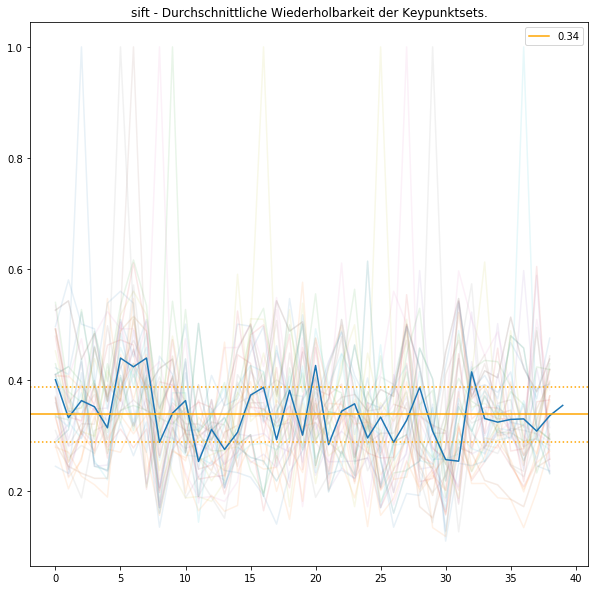

In [51]:
plot_repeatability(collection_name,  set_name, data, config, fs)

In [52]:
stats__perc_matching_kpts_for_e(collection_name, set_name, data, config, fs)

sift:
durchschnittliche Proyzent an gematchen Keypunkten:		0.34+/-0.05
max. Anzahl gematchter Keypunkte:		 0.4388819
min. Anzahl gematchter Keypunkte:		 0.25226623
Anzahl an Extrema:				 13
	davon oberhalb Standardabweichung:	 6
	davon unterhalb Standardabweichung:	 7


### Set St. Louis

In [53]:
set_name = 'stlouis'

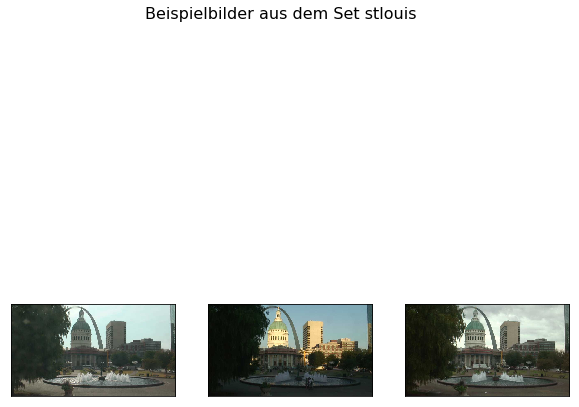

In [54]:
plot_example_images(collection_name, set_name, config, fs)

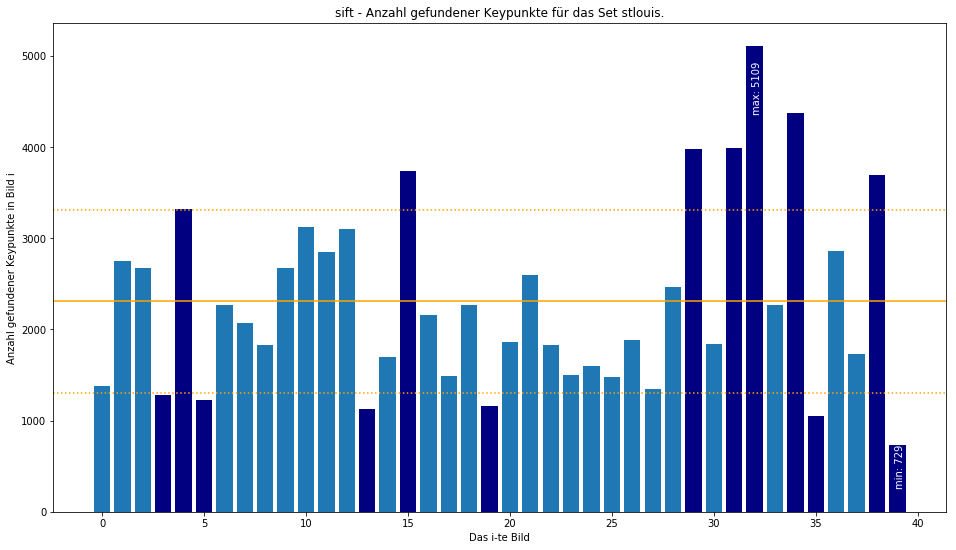

In [55]:
plot_num_kpts(collection_name, set_name, data, config, fs)

In [56]:
eval__num_kpts(collection_name, set_name, data, config, fs)

sift:
durchschnittliche Anzahl Keypunkte:		2309.22+/-1003.96
max. Anzahl gefundener Keypunkte:		 5109
min. Anzahl gefundener Keypunkte:		 729
Anzahl an Extrema:				 13
	davon oberhalb Standardabweichung:	 7
	davon unterhalb Standardabweichung:	 6


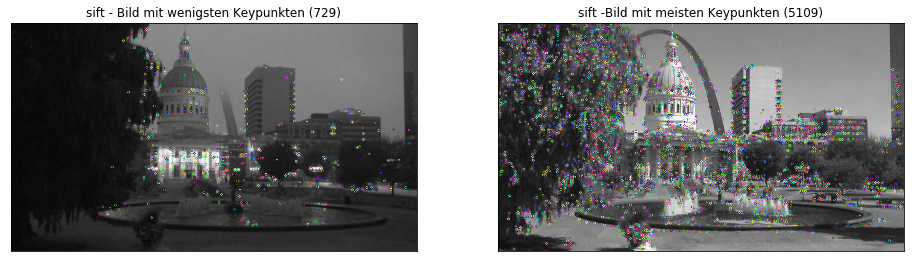

In [57]:
plot_num_kpts_extrema(collection_name, set_name, data, config, fs)

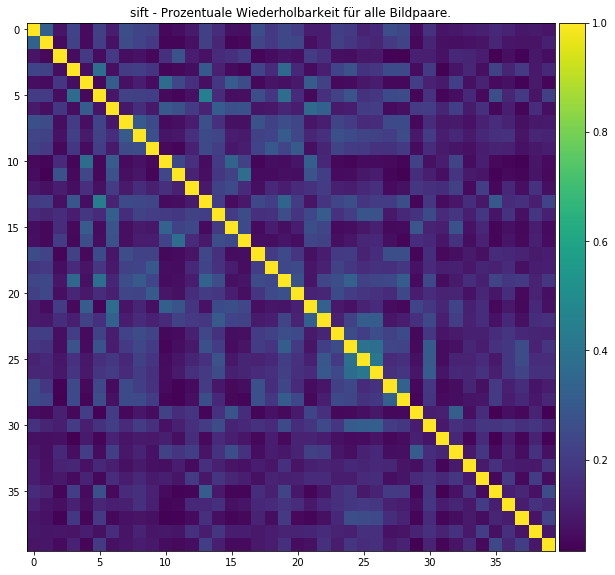

In [58]:
plot_repeatability_heatmap(collection_name, set_name, data, config, fs)

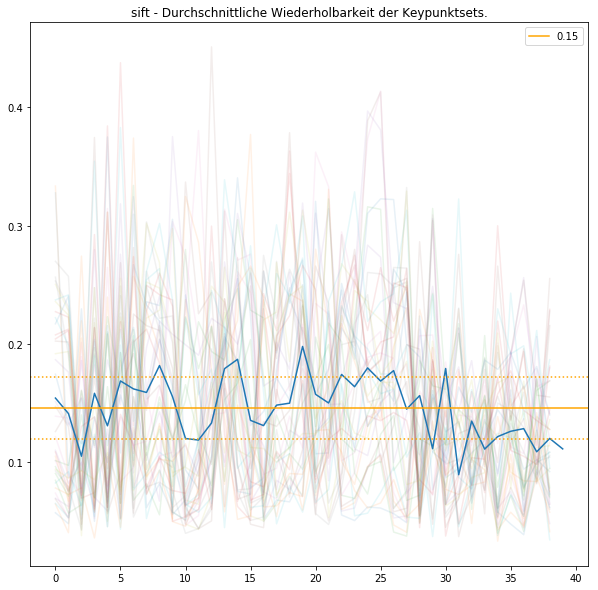

In [59]:
plot_repeatability(collection_name,  set_name, data, config, fs)

In [60]:
stats__perc_matching_kpts_for_e(collection_name, set_name, data, config, fs)

sift:
durchschnittliche Proyzent an gematchen Keypunkten:		0.15+/-0.03
max. Anzahl gematchter Keypunkte:		 0.19775891
min. Anzahl gematchter Keypunkte:		 0.089313775
Anzahl an Extrema:				 15
	davon oberhalb Standardabweichung:	 8
	davon unterhalb Standardabweichung:	 7
